In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy.optimize import curve_fit
import dcor
import random
import collections

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LinearRegression

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/file_master.csv'
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [4]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['starname'] = get_key('Starname')
d['rp'] = get_key('Rp')
d['mp'] = get_key('Mp')
d['ms'] = get_key('Ms')
#d['rs'] = get_key('Rs')
d['p'] = get_key('P')
d['disc_method'] = get_key('Detection Method')

legitimate_entries = either_mass_or_radius(d['mp'], d['rp'])

print('Removed the following systems because they have exoplanets without both a mass and radius:')
for s in d['starname'][legitimate_entries == False]:
    print(s)

d['starname'] = d['starname'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['mp'] = d['mp'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
#d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]

d0 = d.copy()

Removed the following systems because they have exoplanets without both a mass and radius:
51 Eri
Fomalhaut
HIP 41378
HIP 41378
HIP 41378
HIP 41378
HIP 41378
KIC 10001893
KIC 10001893
KIC 10001893
Kepler-37
Kepler-415
Kepler-416
Kepler-417
LkCa 15
LkCa 15
bet Pic


In [5]:
def mass_radius(mp): 
    '''
    mp - float 
    
    Uses the mass-radius relation given in Chen and Kipping (2016).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Earth radii.  The -0.291, 16.580, and -7826.573 
    were calculated using the boundary conditions.
    '''
    mp = float(mp)
    if mp <= 2:                                          
        rp = 10**0.00346*mp**0.2790
    elif mp*MEARTH/MJUPITER <= 0.41:
        rp = 10**-0.0925*mp**0.589
    elif mp*MEARTH/MSUN <= 0.08:
        rp = 10**1.25*mp**-0.044
    else:
        rp = 10**-2.85*mp**0.881
    return rp

for i in range(len(d['mp'])):
    if d['rp'][i] == '' and is_number(d['mp'][i]) == True:
        d['rp'][i] = mass_radius(d['mp'][i])
        
def radius_mass(rp):
    '''
    rp - float  
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2016).  This is kind of like the inverse of mass_radius above.
    '''
    rp = float(rp)
    if rp < 1.23:
        mp = 10**((np.log10(rp)-0.00346)/0.2790)
    elif rp <= 11.1:
        mp = 10**((np.log10(rp)+0.0925)/0.589)
    else:
        mp = 0
    return mp

for i in range(len(d['rp'])):
    if d['mp'][i] == '' and is_number(d['rp'][i]) == True:
        d['mp'][i] = radius_mass(d['rp'][i])

In [6]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0
    
    print('Removed the following systems because they had missing data:')
    for s in d['starname'][empty]:
        print(s)

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

total number of queried objects = 4999
Removed the following systems because they had missing data:
1RXS J160929.1-210524
2MASS J01225093-2439505
2MASS J02192210-3925225
2MASS J04414489+2301513
2MASS J12073346-3932539
2MASS J22362452+4751425
AB Pic
CHXR 73
CT Cha
DH Tau
DP Leo
FU Tau
GJ 504
GQ Lup
GSC 06214-00210
GU Psc
HAT-P-4
HD 100546
HD 106906
HD 203030
HD 95086
HD 97048
HIP 65426
HIP 78530
HIP 79098 AB
HN Peg
HR 2562
HR 8799
HR 8799
HR 8799
HR 8799
KMT-2016-BLG-0212L
KMT-2016-BLG-1107L
KMT-2016-BLG-1397L
KMT-2016-BLG-1820L
KMT-2016-BLG-1836L
KMT-2016-BLG-2142L
KMT-2017-BLG-0165L
KMT-2017-BLG-1038L
KMT-2017-BLG-1146L
KMT-2018-BLG-1990L
Kepler-104
Kepler-104
Kepler-104
Kepler-108
Kepler-108
Kepler-110
Kepler-110
Kepler-111
Kepler-111
Kepler-112
Kepler-112
Kepler-114
Kepler-114
Kepler-114
Kepler-115
Kepler-115
Kepler-116
Kepler-116
Kepler-118
Kepler-118
Kepler-119
Kepler-119
Kepler-120
Kepler-120
Kepler-121
Kepler-121
Kepler-122
Kepler-122
Kepler-122
Kepler-122
Kepler-122
Kepler-123


after removing missing data, number of objects = 4122


In [8]:
def legitimate_periods(periods, detection_method, max_period):
    entries = []
    for i in range(len(periods)):
        if periods[i] <= max_period and detection_method == 'Radial Velocity':
            entries.append(True)
        elif detection_method == 'Transit' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

def legitimate_radii(radii, detection_method, min_radius):
    entries = []
    for i in range(len(radii)):
        if radii[i] >= min_radius and detection_method == 'Transit':
            entries.append(True)
        elif detection_method == 'Radial Velocity' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

uniquesys = np.unique(d['starname'])
systems   = []

max_period = 1460
min_radius = 0.930

for us in uniquesys:
    s = System()
    
    s.sysid = us
    s.starname = d['starname'][d['starname']==us][0]
    s.Mstar = d['ms'][d['starname']==us][0]
    #s.Rstar = d['rs'][d['starname']==us][0]
    
    s.masses = d['mp'][d['starname']==us]
    s.radii = d['rp'][d['starname']==us]
    s.detection_method = d['disc_method'][d['starname']==us][0]
    s.periods = d['p'][d['starname']==us]
    
    legitimate_entries = legitimate_periods(s.periods, s.detection_method, max_period)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    legitimate_entries = legitimate_radii(s.radii, s.detection_method, min_radius)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    s.masses = s.masses[s.radii != 0]
    s.periods = s.periods[s.radii != 0]
    s.radii = s.radii[s.radii != 0]
    
    s.periods = s.periods[s.masses*MEARTH/MJUPITER < 13]
    s.radii = s.radii[s.masses*MEARTH/MJUPITER < 13]
    s.masses = s.masses[s.masses*MEARTH/MJUPITER < 13]
    
    if len(s.masses) >= 3: #and s.Rstar < 4:
    
        order = np.argsort(s.periods)

        s.masses = s.masses[order]     
        s.radii = s.radii[order]
        s.periods = s.periods[order]

        s.N = len(s.masses)
        s.Q = archinfo.Q(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)

        systems.append(s)

In [9]:
Nsys = len(systems)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
Mstar = np.zeros(Nsys)
#Rstar = np.zeros(Nsys)
logmu_over_N = np.zeros(Nsys)
detection_methods = ['']*Nsys
periods = [[0]]*Nsys
masses = [[0]]*Nsys
radii = [[0]]*Nsys
starnames = ['']*Nsys

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    Mstar[i] = s.Mstar
    #Rstar[i] = s.Rstar
    logmu_over_N[i] = np.log10(s.mu/s.N)
    detection_methods[i] = s.detection_method
    periods[i] = s.periods
    masses[i] = s.masses
    radii[i] = s.radii
    starnames[i] = s.starname

logmu = np.log10(mu)
detection_methods = np.array(detection_methods)
starnames = np.array(starnames)

In [10]:
#Setting lower boundary for dynamical mass

min_logmu = min(logmu[detection_methods == 'Radial Velocity'])

print('Removed the following systems because they had logmu below %.3f:' % min_logmu)
for s in starnames[logmu < min_logmu]:
    print(s)

N = N[logmu >= min_logmu]
Q = Q[logmu >= min_logmu]
M = M[logmu >= min_logmu]
S = S[logmu >= min_logmu]
C = C[logmu >= min_logmu]
Mstar = Mstar[logmu >= min_logmu]
#Rstar = Rstar[logmu >= min_logmu]
logmu_over_N = logmu_over_N[logmu >= min_logmu]
detection_methods = detection_methods[logmu >= min_logmu]

sv_periods = []
sv_masses = []
sv_radii = []
for i in range(len(logmu)):
    if logmu[i] >= min_logmu:
        sv_periods.append(periods[i])
        sv_masses.append(masses[i])
        sv_radii.append(radii[i])
periods = np.array(sv_periods)
masses = np.array(sv_masses)
radii = np.array(sv_radii)

starnames = starnames[logmu >= min_logmu]
mu = mu[logmu >= min_logmu]
logmu = logmu[logmu >= min_logmu]

#Setting upper boundary for dynamical mass

max_logmu = max(logmu[detection_methods == 'Transit'])

print('Removed the following systems because they had exoplanets with a logmu above %.3f:' % max_logmu)
for s in starnames[logmu > max_logmu]:
    print(s)

N = N[logmu <= max_logmu]
Q = Q[logmu <= max_logmu]
M = M[logmu <= max_logmu]
S = S[logmu <= max_logmu]
C = C[logmu <= max_logmu]
Mstar = Mstar[logmu <= max_logmu]
#Rstar = Rstar[logmu <= max_logmu]
logmu_over_N = logmu_over_N[logmu <= max_logmu]
detection_methods = detection_methods[logmu <= max_logmu]

sv_periods = []
sv_masses = []
sv_radii = []
for i in range(len(logmu)):
    if logmu[i] <= max_logmu:
        sv_periods.append(periods[i])
        sv_masses.append(masses[i])
        sv_radii.append(radii[i])
periods = np.array(sv_periods)
masses = np.array(sv_masses)
radii = np.array(sv_radii)

starnames = starnames[logmu <= max_logmu]
mu = mu[logmu <= max_logmu]
logmu = logmu[logmu <= max_logmu]

Removed the following systems because they had logmu below -4.444:
K00041
K00282
K00623
K00664
K00671
K01905
K01909
K01931
K02004
K02597
K02722
K04032
K2-219
K2-239
Kepler-1254
Kepler-60
Kepler-770
Removed the following systems because they had exoplanets with a logmu above -2.039:


# Raw Variables: Mass, Radius, Period

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:89: UserWarning: p-value floored: true value smaller than 0.001


9


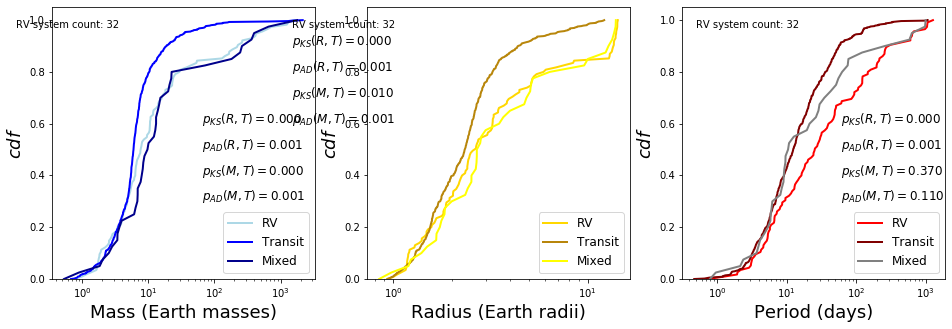

In [11]:
m_rv = []
r_rv = []
p_rv = []
m_transit = []
r_transit = []
p_transit = []
m_mixed = []
r_mixed = []
p_mixed = []
rv_count = 0
for i in range(len(masses)):
    for j in range(len(masses[i])):
        if detection_methods[i] == 'Radial Velocity':
            m_rv.append(masses[i][j])
            r_rv.append(radii[i][j])
            p_rv.append(periods[i][j])
            rv_count = rv_count + 1/len(masses[i])
        elif detection_methods[i] == 'Transit':
            m_transit.append(masses[i][j])
            r_transit.append(radii[i][j])
            p_transit.append(periods[i][j])
        elif detection_methods[i] == 'Mixed':
            m_mixed.append(masses[i][j])
            r_mixed.append(radii[i][j])
            p_mixed.append(periods[i][j])
            
m_rv = np.sort(np.squeeze(m_rv))
m_transit = np.sort(np.squeeze(m_transit))
m_mixed = np.sort(np.squeeze(m_mixed))
r_rv = np.sort(np.squeeze(r_rv))
r_transit = np.sort(np.squeeze(r_transit))
r_mixed = np.sort(np.squeeze(r_mixed))
p_rv = np.sort(np.squeeze(p_rv))
p_transit = np.sort(np.squeeze(p_transit))
p_mixed = np.sort(np.squeeze(p_mixed))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ax = axes[0]
ax.set_xscale('log')
ax.set_xlabel('Mass (Earth masses)', fontsize=18)
ax.plot(m_rv, np.linspace(0, 1, len(m_rv)), lw=2, color='lightblue', label='RV')
ax.plot(m_transit, np.linspace(0, 1, len(m_transit)), lw=2, color='blue', label='Transit')
ax.plot(m_mixed, np.linspace(0, 1, len(m_mixed)), lw=2, color='darkblue', label='Mixed')
ax.set_ylim(0, 1.05)
ax.set_ylabel(r'$cdf$', fontsize=18)
ax.legend(loc = 'lower right', fontsize=12)

KS = np.array(stats.ks_2samp(m_rv, m_transit))[1]
AD = stats.anderson_ksamp([m_rv, m_transit])[2]
ax.text(65, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(65, 0.55, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(m_mixed, m_transit))[1]
AD = stats.anderson_ksamp([m_mixed, m_transit])[2]
ax.text(65, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(65, 0.35, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(10**-1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax = axes[1]
ax.set_xscale('log')
ax.set_xlabel('Radius (Earth radii)', fontsize=18)
ax.plot(r_rv, np.linspace(0, 1, len(r_rv)), lw=2, color='gold', label='RV')
ax.plot(r_transit, np.linspace(0, 1, len(r_transit)), lw=2, color='darkgoldenrod', label='Transit')
ax.plot(r_mixed, np.linspace(0, 1, len(r_mixed)), lw=2, color='yellow', label='Mixed')
ax.set_ylim(0, 1.05)
ax.set_ylabel(r'$cdf$', fontsize=18)
ax.legend(loc = 'lower right', fontsize=12)

KS = np.array(stats.ks_2samp(r_rv, r_transit))[1]
AD = stats.anderson_ksamp([r_rv, r_transit])[2]
ax.text(3*10**-1, 0.95, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(3*10**-1, 0.85, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(r_mixed, r_transit))[1]
AD = stats.anderson_ksamp([r_mixed, r_transit])[2]
ax.text(3*10**-1, 0.75, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(3*10**-1, 0.65, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(3*10**-1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax = axes[2]
ax.set_xscale('log')
ax.set_xlabel('Period (days)', fontsize=18)
ax.plot(p_rv, np.linspace(0, 1, len(p_rv)), lw=2, color='red', label='RV')
ax.plot(p_transit, np.linspace(0, 1, len(p_transit)), lw=2, color='maroon', label='Transit')
ax.plot(p_mixed, np.linspace(0, 1, len(p_mixed)), lw=2, color='grey', label='Mixed')
ax.set_ylim(0, 1.05)
ax.set_ylabel(r'$cdf$', fontsize=18)
ax.legend(loc = 'lower right', fontsize=12)

KS = np.array(stats.ks_2samp(p_rv, p_transit))[1]
AD = stats.anderson_ksamp([p_rv, p_transit])[2]
ax.text(60, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(60, 0.55, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(p_mixed, p_transit))[1]
AD = stats.anderson_ksamp([p_mixed, p_transit])[2]
ax.text(60, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(60, 0.35, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(5*10**-1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

print(len(m_rv[m_rv > 300]))

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Mass_Radius_Period.pdf', bbox_inches='tight')
plt.show()

# Raw Variables: Stellar Mass, Radius

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: p-value capped: true value larger than 0.25


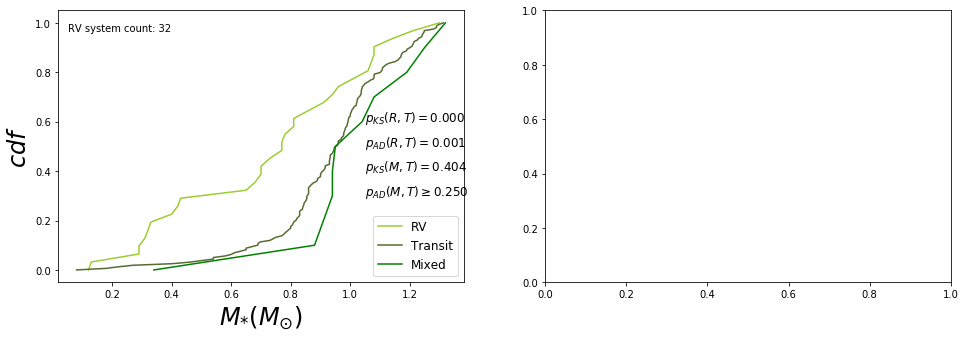

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]

ax.set_xlabel(r'$M_{*} (M_{\odot})$', fontsize=24)
ax.set_ylabel(r'$cdf$', fontsize=24)

Mstar_transit = np.sort(np.squeeze(Mstar[detection_methods == 'Transit']))
Mstar_rv = np.sort(np.squeeze(Mstar[detection_methods == 'Radial Velocity']))
Mstar_mixed = np.sort(np.squeeze(Mstar[detection_methods == 'Mixed']))

ax.plot(Mstar_rv, np.linspace(0, 1, len(Mstar_rv)), color='yellowgreen', label='RV')
ax.plot(Mstar_transit, np.linspace(0, 1, len(Mstar_transit)), color='darkolivegreen', label='Transit')
ax.plot(Mstar_mixed, np.linspace(0, 1, len(Mstar_mixed)), color='green', label='Mixed')

ax.legend(loc = 'lower right', fontsize=12)

KS = np.array(stats.ks_2samp(Mstar_rv, Mstar_transit))[1]
AD = stats.anderson_ksamp([Mstar_rv, Mstar_transit])[2]
ax.text(1.05, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(1.05, 0.55, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(Mstar_mixed, Mstar_transit))[1]
AD = stats.anderson_ksamp([Mstar_mixed, Mstar_transit])[2]
ax.text(1.05, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(1.05, 0.35, r'$p_{AD}(M, T)\geq%.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(0.05, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax = axes[1]

'''
ax.set_xlabel(r'$R_{*} (R_{\odot})$', fontsize=24)
ax.set_ylabel(r'$cdf$', fontsize=24)

Rstar_transit = np.sort(np.squeeze(Rstar[detection_methods == 'Transit']))
Rstar_rv = np.sort(np.squeeze(Rstar[detection_methods == 'Radial Velocity']))
Rstar_mixed = np.sort(np.squeeze(Rstar[detection_methods == 'Mixed']))

ax.plot(Rstar_rv, np.linspace(0, 1, len(Rstar_rv)), color='yellowgreen', label='RV')
ax.plot(Rstar_transit, np.linspace(0, 1, len(Rstar_transit)), color='darkolivegreen', label='Transit')
ax.plot(Rstar_mixed, np.linspace(0, 1, len(Rstar_mixed)), color='green', label='Mixed')

ax.legend(loc = 'lower right', fontsize=12)

KS = np.array(stats.ks_2samp(Rstar_rv, Rstar_transit))[1]
AD = stats.anderson_ksamp([Rstar_rv, Rstar_transit])[2]
ax.text(1.4, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(1.4, 0.55, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(Rstar_mixed, Rstar_transit))[1]
AD = stats.anderson_ksamp([Rstar_mixed, Rstar_transit])[2]
ax.text(1.4, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(1.4, 0.35, r'$p_{AD}(M, T)\geq%.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(0.1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')
'''

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Stellar_Mass_Radius_cdf.pdf', bbox_inches='tight')
plt.show()

# Galleries (RV, Mixed Systems)

55 Cnc 0.0012256227278085077 [ 1.86546382 13.91396778  8.51362029  7.58877999]
61 Vir 0.00014724459593400054 [2.10624348 4.45135463 5.10799831]
DMPP-1 0.00010262608444543107 [1.64715711 1.86293497 3.0620057  5.28798156]
GJ 1061 0.00011884162111831781 [1.1004907  1.17615804 1.15716819]
GJ 163 0.00035139415079663233 [3.24627535 2.49974448 5.92024099]
GJ 180 0.0001428496930786168 [2.43167055 2.41197571 2.6605917 ]
GJ 3138 7.270030188657783e-05 [1.18389089 1.8764162  3.22846801]
GJ 3293 0.00039693419637242694 [1.62681904 5.1935786  2.66848813 4.86838327]
GJ 581 0.00022262596727178072 [1.16584331 4.10615953 2.20541874]
GJ 667 C 0.0001735547588438376 [2.25755017 1.77795047 1.40023815 1.40023815 1.9469344 ]
GJ 676 A 0.006536714132920403 [ 1.9469344   2.73948275 12.86183827]
GJ 876 0.009118350086206673 [ 2.47211728 14.0067109  13.3104279   3.92325257]
HD 10180 0.0002749287484081414 [3.69766767 3.49481809 5.4550116  5.1163508  5.15797142]
HD 136352 8.968067199270152e-05 [2.03563227 3.2833939  2

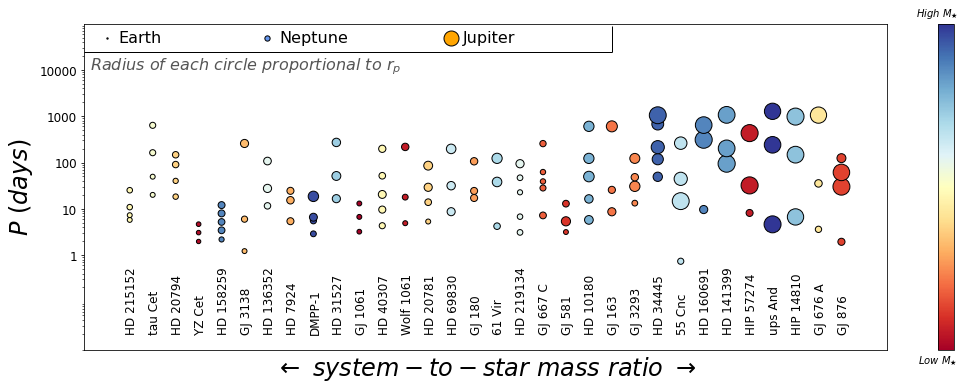

In [13]:
mu_rv = []
masses_rv = []
periods_rv = []
radii_rv = []
Mstar_rv = []
starnames_rv = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity' and len(periods[i]) > 2:
        mu_rv.append(mu[i])
        periods_rv.append(periods[i])
        masses_rv.append(masses[i])
        radii_rv.append(radii[i])
        Mstar_rv.append(Mstar[i])
        starnames_rv.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(radii[i]))

mu_rank = np.array(stats.rankdata(mu_rv), dtype = 'int')
mu_pos = []
for i in range(len(masses_rv)):
    for j in range(len(masses_rv[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')


ms_final = []
for i in range(len(masses_rv)):
    arr = []
    for j in range(len(masses_rv[i])):
        arr.append(Mstar_rv[i])
    ms_final.append(arr)
    

ms_rank = np.array(stats.rankdata([item for sublist in ms_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_rv for item in sublist], c = ms_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_rv for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(ms_rank), max(ms_rank))
cbar.set_ticks([])

for i in range(len(radii_rv)):
    plt.text(mu_rank[i]-0.2, 0.02, starnames_rv[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

cbar.ax.text(1, -5, r"$Low\ M_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 120, r"$High\ M_{\bigstar}$", va = 'top', ha = 'center')

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(0.5, 50000, 'Earth', va='center', fontsize=16)
plt.plot(7, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(7.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(15, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(15.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.75,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/gallery.pdf', bbox_inches='tight')
plt.show()

GJ 357 0.0001001717231632785 [1.19609151 1.66183901 2.34429934]
HD 3167 5.929722111674632e-05 [1.66794412 2.52100984 2.79819573]
Kepler-19 0.00014058304731795194 [2.83072144 3.67773565 5.05726093]
Kepler-20 0.00017041355481925598 [1.83254387 0.84494538 2.98474211 0.97662518 4.71281221 2.68846256]
Kepler-25 0.0002417661543995207 [ 2.68846256  5.10259221 10.0196321 ]
Kepler-48 0.0023325434173438945 [ 1.84351719  2.65554261  1.99714362 13.36685562]
Kepler-56 0.0045196551782249374 [ 6.37549694  9.5906787  12.79233642]
Kepler-65 0.0006556633534686247 [ 1.39361121  2.52386282  1.49237106 13.92183328]
Kepler-68 0.0007075080268407125 [ 2.67899142  1.23004227 13.9604252 ]
Kepler-82 0.00018817123882488044 [1.73378402 2.41412965 3.98331392 5.2232987  4.84240833]
WASP-47 0.0022560541637707474 [ 1.76670397 12.3669278   3.50048799 13.6645827 ]


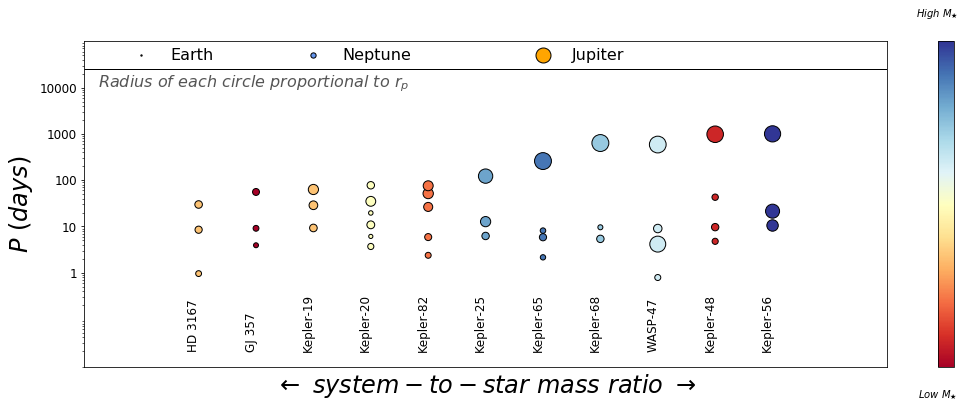

In [14]:
mu_mixed = []
masses_mixed = []
periods_mixed = []
radii_mixed = []
Mstar_mixed = []
starnames_mixed = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Mixed' and len(periods[i]) > 2:
        mu_mixed.append(mu[i])
        periods_mixed.append(periods[i])
        masses_mixed.append(masses[i])
        radii_mixed.append(radii[i])
        Mstar_mixed.append(Mstar[i])
        starnames_mixed.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(radii[i]))
        
mu_rank = np.array(stats.rankdata(mu_mixed), dtype = 'int')
mu_pos = []
for i in range(len(masses_mixed)):
    for j in range(len(masses_mixed[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

ms_final = []
for i in range(len(masses_mixed)):
    arr = []
    for j in range(len(masses_mixed[i])):
        arr.append(Mstar_mixed[i])
    ms_final.append(arr)
    
ms_rank = np.array(stats.rankdata([item for sublist in ms_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_mixed for item in sublist], c = ms_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_mixed for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(ms_rank), max(ms_rank))
cbar.set_ticks([])

for i in range(len(radii_mixed)):
    plt.text(mu_rank[i]-0.2, 0.02, starnames_mixed[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

cbar.ax.text(1, -3, r"$Low\ M_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 43, r"$High\ M_{\bigstar}$", va = 'top', ha = 'center')

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(0.5, 50000, 'Earth', va='center', fontsize=16)
plt.plot(3, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(3.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(7, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(7.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.75,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/gallery_mixed.pdf', bbox_inches='tight')
plt.show()

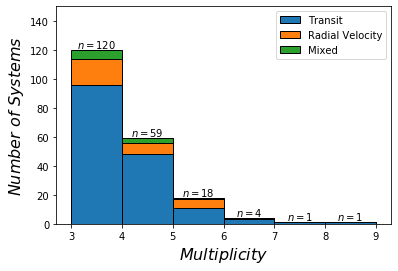

There are 160 transit systems.
There are 32 RV systems.
There are 11 mixed systems.


In [15]:
'''
Making a histogram of combined star systems' multiplicities.  No divisions were made based on stellar masses or 
detection methods.
'''
plt.ylim(0, 150)
plt.ylabel(r'$Number\ of\ Systems$', fontsize=16)
plt.xlabel(r'$Multiplicity$', fontsize=16)               #making a histogram
n = [[], [], []]
for i in range(len(N)):
    if detection_methods[i] == 'Transit':
        n[0].append(N[i])
    elif detection_methods[i] == 'Radial Velocity':
        n[1].append(N[i])
    elif detection_methods[i] == 'Mixed':
        n[2].append(N[i])
N_transit = np.array(n[0])
N_rv = np.array(n[1])
N_mixed = np.array(n[2])
plt.hist(n, bins = np.arange(3, 10, 1), edgecolor = 'k', histtype='bar', stacked=True, label=['Transit', 'Radial Velocity', \
                                                                                              'Mixed'])
plt.legend(loc='upper right')
for i in range(3, 9):
    plt.text(i+0.5, np.sum(N_transit==i)+np.sum(N_rv==i)+np.sum(N_mixed==i), \
            r'$n = %d$' %(np.sum(N_transit==i)+np.sum(N_rv==i)+np.sum(N_mixed==i)), \
            va = 'bottom', ha = 'center', fontsize=10)
plt.xticks([3, 4, 5, 6, 7, 8, 9])

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/N_Histogram.pdf', bbox_inches='tight')
plt.show()

print('There are %d transit systems.' %len(N_transit))
print('There are %d RV systems.' %len(N_rv))
print('There are %d mixed systems.' %len(N_mixed))

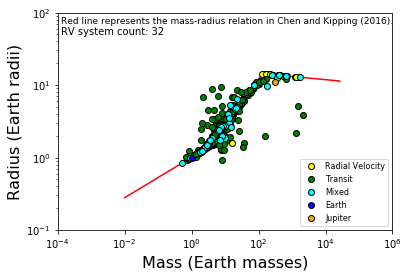

In [16]:
mp = np.array([item for sublist in masses for item in sublist])
rp = np.array([item for sublist in radii for item in sublist])

d = []
for i in range(len(detection_methods)):
    for j in range(len(masses[i])):
        d.append(detection_methods[i])
d = np.array(d)

x = np.linspace(0.01, 2, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

x = np.linspace(2, 0.41*MJUPITER/MEARTH, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

x = np.linspace(0.41*MJUPITER/MEARTH, 0.08*MSUN/MEARTH, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

plt.plot(mp[d=='Radial Velocity'], rp[d=='Radial Velocity'], 'o', color='yellow', mec='black', label='Radial Velocity')
plt.plot(mp[d=='Transit'], rp[d=='Transit'], 'o', color='green', mec='black', label='Transit')
plt.plot(mp[d=='Mixed'], rp[d=='Mixed'], 'o', color='cyan', mec='black', label='Mixed')
                                                                                    #add in Earth and Jupiter for reference
plt.plot(1, 1, 'o', color='blue', mec='black', label='Earth')                                                 #Earth
plt.plot(MJUPITER/MEARTH, RJUPITER/REARTH, 'o', color='orange', mec='black', label='Jupiter')                 #Jupiter

plt.xlabel('Mass (Earth masses)', fontsize=16)
plt.xscale("log")
plt.xlim(10**-4, 10**6)
plt.ylabel('Radius (Earth radii)', fontsize=16)
plt.yscale("log")
plt.ylim(10**-1, 10**2)
plt.text(10**-3.9, 70, 'Red line represents the mass-radius relation in Chen and Kipping (2016).', fontsize=9)
plt.text(10**-3.9, 50, 'RV system count: %.0f' %len(masses[detection_methods == 'Radial Velocity']), fontsize=10)

plt.legend(loc='lower right', fontsize=8)

'''
There are a couple RV planets whose radii are already known.  This is for all planets, regardless of N.
'''

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Mass_Radius_Relation.pdf', bbox_inches='tight')
plt.show()

In [17]:
Q_rv = []
Q_transit = []
Q_mixed = []
M_rv = []
M_transit = []
M_mixed = []
S_rv = []
S_transit = []
S_mixed = []
C_rv = []
C_transit = []
C_mixed = []
N_rv = []
N_transit = []
N_mixed = []
logmu_rv = []
logmu_transit = []
logmu_mixed = []
logmu_over_N_rv = []
logmu_over_N_transit = []
logmu_over_N_mixed = []
for i in range(len(detection_methods)):
    if len(periods[i]) > 2:
        if detection_methods[i] == 'Radial Velocity':
            Q_rv.append(Q[i])
            M_rv.append(M[i])
            S_rv.append(S[i])
            C_rv.append(C[i])
            N_rv.append(N[i])
            logmu_rv.append(logmu[i])
            logmu_over_N_rv.append(logmu_over_N[i])
        elif detection_methods[i] == 'Transit':
            Q_transit.append(Q[i])
            M_transit.append(M[i])
            S_transit.append(S[i])
            C_transit.append(C[i])
            N_transit.append(N[i])
            logmu_transit.append(logmu[i])
            logmu_over_N_transit.append(logmu_over_N[i])
        elif detection_methods[i] == 'Mixed':
            Q_mixed.append(Q[i])
            M_mixed.append(M[i])
            S_mixed.append(S[i])
            C_mixed.append(C[i])
            N_mixed.append(N[i])
            logmu_mixed.append(logmu[i])
            logmu_over_N_mixed.append(logmu_over_N[i])
Q_rv = np.array(Q_rv)
Q_transit = np.array(Q_transit)
Q_mixed = np.array(Q_mixed)
M_rv = np.array(M_rv)
M_transit = np.array(M_transit)
M_mixed = np.array(M_mixed)
S_rv = np.array(S_rv)
S_transit = np.array(S_transit)
S_mixed = np.array(S_mixed)
C_rv = np.array(C_rv)
C_transit = np.array(C_transit)
C_mixed = np.array(C_mixed)
N_rv = np.array(N_rv)
N_transit = np.array(N_transit)
N_mixed = np.array(N_mixed)
logmu_rv = np.array(logmu_rv)
logmu_transit = np.array(logmu_transit)
logmu_mixed = np.array(logmu_mixed)
logmu_over_N_rv = np.array(logmu_over_N_rv)
logmu_over_N_transit = np.array(logmu_over_N_transit)
logmu_over_N_mixed = np.array(logmu_over_N_mixed)

# Mstar vs. logmu

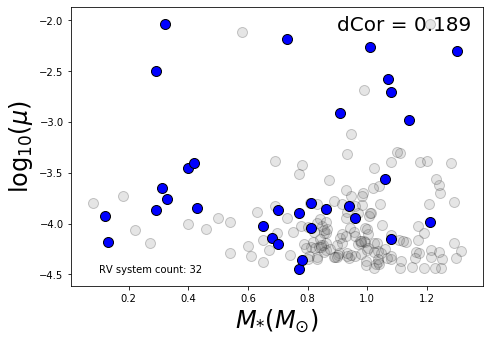

In [18]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Mstar[detection_methods == 'Transit'], logmu[detection_methods == 'Transit'], \
           s=100, color = 'grey', edgecolor = 'k', alpha=0.2)
ax1.scatter(Mstar[detection_methods == 'Radial Velocity'], logmu[detection_methods == 'Radial Velocity'], \
           s=100, color = 'blue', edgecolor = 'k')

ax1.text(0.9, -2.1, 'dCor = %.3f' %dcor.distance_correlation(Mstar, logmu), fontsize=20)
ax1.text(0.1, -4.4, 'RV system count: %d' %len(Mstar[detection_methods == 'Radial Velocity']), \
         fontsize=10, ha='left', va='top')

ax1.set_xlabel(r'$M_{*}(M_{\odot})$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}({\mu})$', fontsize=24)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Mstar_logmu.pdf', bbox_inches='tight')
plt.show()

# Q vs. P

dCor = 0.486


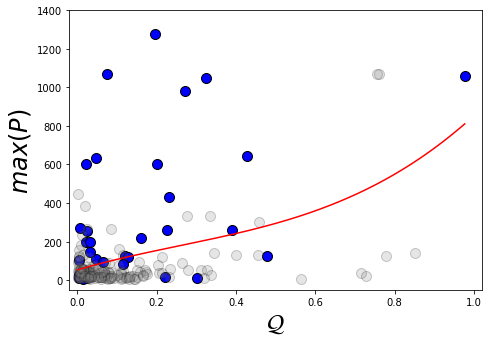

In [19]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)

max_p_rv = []
max_p_transit = []
max_p = []
for i in range(len(periods)):
    if detection_methods[i] == 'Radial Velocity':
        max_p_rv.append(max(periods[i]))
    elif detection_methods[i] == 'Transit':
        max_p_transit.append(max(periods[i]))
    max_p.append(max(periods[i]))
max_p_rv = np.array(max_p_rv)
max_p_transit = np.array(max_p_transit)
max_p = np.array(max_p)

ax1.scatter(Q[detection_methods == 'Radial Velocity'], max_p_rv, s=100, color='blue', edgecolor='k')
ax1.scatter(Q[detection_methods == 'Transit'], max_p_transit, s=100, color='grey', edgecolor='k', alpha = 0.2)

print('dCor = %.3f' %dcor.distance_correlation(Q, max_p))

weights = np.polyfit(Q, max_p, 3)
model = np.poly1d(weights)
pred = model(Q)
xp = np.linspace(Q.min(), Q.max(), 1000)
pred_plot = model(xp)
plt.plot(xp, pred_plot, c='red')

ax1.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax1.set_xlim(-0.02, 1.02)
ax1.set_ylabel(r'$max(P)$', fontsize=24)
ax1.set_ylim(-50, 1400)

plt.show()

dCor = 0.491
RV system count: 32


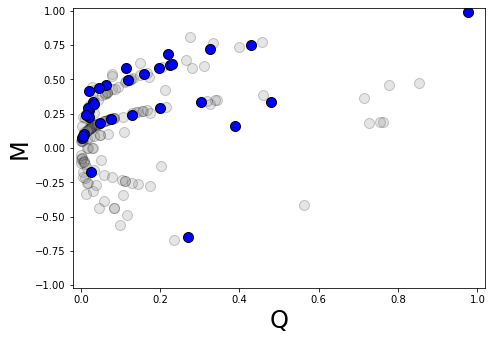

dCor = 0.164
RV system count: 32


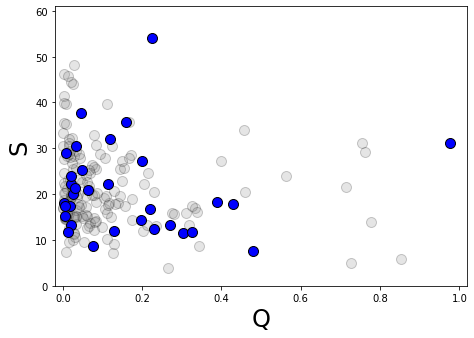

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def isupper(arr):
    entries = []
    for s in arr:
        if s.isupper() == True:
            entries.append(True)
        else:
            entries.append(False)
    return entries

system_parameters = [Q, M, S, C]
for i in system_parameters:
    revised_system_parameters = []
    for k in system_parameters:
        if np.array_equal(i, k) == False:
            revised_system_parameters.append(k)
    for j in revised_system_parameters:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)

        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(i[detection_methods == 'Transit'], j[detection_methods == 'Transit'], s=100, \
                   edgecolor = 'k', color='grey', alpha=0.2)
        ax1.scatter(i[detection_methods == 'Radial Velocity'], j[detection_methods == 'Radial Velocity'], s=100, \
                   edgecolor = 'k', color='blue')
        print('dCor = %.3f' %dcor.distance_correlation(i, j))
        print('RV system count: %.0f' %len(i[detection_methods == 'Radial Velocity']))
        
        if np.array_equal(i, Q):
            ax1.set_xlim(-0.02, 1.02)
        elif np.array_equal(i, M):
            ax1.set_xlim(-1.02, 1.02)
        elif np.array_equal(i, S):
            ax1.set_xlim(-0.02, 61)
        elif np.array_equal(i, C):
            ax1.set_xlim(-0.02, 1.02)
            
        if np.array_equal(j, Q):
            ax1.set_ylim(-0.02, 1.02)
        elif np.array_equal(j, M):
            ax1.set_ylim(-1.02, 1.02)
        elif np.array_equal(j, S):
            ax1.set_ylim(-0.02, 61)
        elif np.array_equal(j, C):
            ax1.set_ylim(-0.02, 1.02)
        
        ax1.set_xlabel(namestr(i, globals())[1], fontsize=24)
        ax1.set_ylabel(namestr(j, globals())[0], fontsize=24)
        
        plt.show()

# Mass partitioning, Q

In [ ]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q_rv[N_rv==4], logmu_rv[N_rv==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q_rv[N_rv==5], logmu_rv[N_rv==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q_rv[N_rv>=6], logmu_rv[N_rv>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_ylim(-4.6, -1.8)
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.text(0, -2, 'RV system count: %.0f' %len(Q_rv), fontsize=10)

# Q historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q_rv[N_rv>2], Q_rv[N_rv>2]])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(Q_rv[N_rv>2], bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
ax1h.plot(x[500:], y[500:]*2, c='#ff8800', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv[N_rv>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_rv[N_rv>2],bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_ylim(-4.6, -1.8)
axsh.set_yticks([])
axsh.set_xticks([])
ax1h.tick_params(labelsize=16)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Q_Scatter.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#Q cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

Q_rv = np.sort(np.squeeze(Q_rv))
Q_transit = np.sort(np.squeeze(Q_transit))
Q_mixed = np.sort(np.squeeze(Q_mixed))

KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]
ax.text(0.75, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(0.75, 0.55, r'$p_{AD}(R, T)\geq%.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(Q_mixed, Q_transit))[1]
AD = stats.anderson_ksamp([Q_mixed, Q_transit])[2]
ax.text(0.75, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(0.75, 0.35, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(0, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(Q_rv, np.linspace(0,1,len(Q_rv)), lw=2, color='bisque', label='RV')
ax.plot(Q_transit, np.linspace(0,1,len(Q_transit)), lw=2, color='orange', label='Transit')
ax.plot(Q_mixed, np.linspace(0, 1, len(Q_mixed)), lw=2, color='sienna', label='Mixed')

ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=12)


plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Q_cdf.pdf', bbox_inches='tight')

plt.show()

# Monotonicity, M

In [ ]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M_rv[N_rv==4], logmu_rv[N_rv==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M_rv[N_rv==5], logmu_rv[N_rv==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M_rv[N_rv>=6], logmu_rv[N_rv>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1.02,1.02)
ax1.set_ylim(-4.6, -1.8)
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower left',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.text(-1, -2, 'RV system count: %.0f' %len(M_rv), fontsize=10)


# M historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_rv[N_rv>2])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(M_rv[N_rv>2], bins=np.arange(-1,1,0.1), density=True, color='lemonchiffon', edgecolor='k')
ax1h.plot(x, y, c='#fcba03', lw=3)
ax1h.set_xlim(-1.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv[N_rv>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_rv[N_rv>2],bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_ylim(-4.6, -1.8)
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/M_Scatter.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#M cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

M_rv = np.sort(np.squeeze(M_rv))
M_transit = np.sort(np.squeeze(M_transit))
M_mixed = np.sort(np.squeeze(M_mixed))

KS = np.array(stats.ks_2samp(M_rv, M_transit))[1]
AD = stats.anderson_ksamp([M_rv, M_transit])[2]
ax.text(-1, 0.95, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-1, 0.85, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(M_mixed, M_transit))[1]
AD = stats.anderson_ksamp([M_mixed, M_transit])[2]
ax.text(-1, 0.75, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-1, 0.65, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(-1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(M_rv, np.linspace(0,1,len(M_rv)), lw=2, color='gold', label='RV')
ax.plot(M_transit, np.linspace(0,1,len(M_transit)), lw=2, color='orange', label='Transit')
ax.plot(M_mixed, np.linspace(0, 1, len(M_mixed)), lw=2, color='bisque', label='Mixed')

ax.set_xlim(-1.02,1.02)
ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=12)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/M_cdf.pdf', bbox_inches='tight')
plt.show()

# Characteristic spacing, S

In [ ]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S_rv[N_rv==4], logmu_rv[N_rv==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S_rv[N_rv==5], logmu_rv[N_rv==5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
ax1.scatter(S_rv[N_rv>=6], logmu_rv[N_rv>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1,61)
ax1.set_ylim(-4.6, -1.8)
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='upper right',frameon=True, fontsize=12)
ax1.tick_params(labelsize=16)
ax1.text(45, -2.8, 'RV system count: %.0f' %len(S_rv), fontsize=10)


# S historgram
x = np.linspace(0,60,1000)
y = FFTKDE(kernel='gaussian', bw='ISJ').fit(S_rv[N_rv>2]).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(S_rv[N_rv>2], bins=np.arange(0.0,60.0,2.5), color='thistle', edgecolor='black', density=True)
ax1h.plot(x, y, lw=3, c='indigo')
ax1h.set_yticks([])
ax1h.set_xlim(-1,61)
ax1h.tick_params(labelsize=16)

# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv[N_rv>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_rv[N_rv>2],bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_ylim(-4.6, -1.8)
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/S_Scatter.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#S cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

S_rv = np.sort(np.squeeze(S_rv))
S_transit = np.sort(np.squeeze(S_transit))
S_mixed = np.sort(np.squeeze(S_mixed))

KS = np.array(stats.ks_2samp(S_rv, S_transit))[1]
AD = stats.anderson_ksamp([S_rv, S_transit])[2]
ax.text(46, 0.65, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(46, 0.55, r'$p_{AD}(R, T)\geq%.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(S_mixed, S_transit))[1]
AD = stats.anderson_ksamp([S_mixed, S_transit])[2]
ax.text(46, 0.45, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(46, 0.35, r'$p_{AD}(M, T)\geq%.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(1, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(S_rv, np.linspace(0,1,len(S_rv)), lw=2, color='thistle', label='RV')
ax.plot(S_transit, np.linspace(0,1,len(S_transit)), lw=2, color=royalpurple, label='Transit')
ax.plot(S_mixed, np.linspace(0, 1, len(S_mixed)), lw=2, color='indigo', label='Mixed')

ax.set_xlim(-0.02,61)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=12)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/S_cdf.pdf', bbox_inches='tight')
plt.show()

# Gap complexity, C

In [ ]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C_rv[N_rv==4], logmu_rv[N_rv==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
ax1.scatter(C_rv[N_rv==5], logmu_rv[N_rv==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C_rv[N_rv>=6], logmu_rv[N_rv>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_ylim(-4.6, -1.8)
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='upper right',frameon=True, fontsize=12)
ax1.tick_params(labelsize=16)
ax1.text(0, -2, 'RV system count: %.0f' %len(C_rv), fontsize=10)


# C historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-C_rv[N_rv>2], C_rv[N_rv>2]])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(C_rv[N_rv>2], bins=np.arange(0,1,0.05), density=True, color=robinseggblue, edgecolor='k')
ax1h.plot(x[500:],y[500:]*2, c='mediumblue', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])

# 4- and 5-planet systems with second-to-last planet removed
P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

ax1h.axvline(C43, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.37,0.37,0.37], [2.4,3.9,6.9], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.37], [5.4], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

ax1h.axvline(C54, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.24,0.24,0.24,0.24], [1.3,2.6,3.9,6.5], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.24], [5.2], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv[N_rv>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_rv[N_rv>2],bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_ylim(-4.6, -1.8)
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/C_scatter.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#C cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

C_rv = np.sort(np.squeeze(C_rv))
C_transit = np.sort(np.squeeze(C_transit))
C_mixed = np.sort(np.squeeze(C_mixed))

KS = np.array(stats.ks_2samp(C_rv, C_transit))[1]
AD = stats.anderson_ksamp([C_rv, C_transit])[2]
ax.text(0.75, 0.7, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(0.75, 0.6, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(C_mixed, C_transit))[1]
AD = stats.anderson_ksamp([C_mixed, C_transit])[2]
ax.text(0.75, 0.5, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(0.75, 0.4, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(0.01, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(C_rv, np.linspace(0,1,len(C_rv)), lw=2, color='cornflowerblue', label='RV')
ax.plot(C_transit, np.linspace(0,1,len(C_transit)), lw=2, color='mediumblue', label='Transit')
ax.plot(C_mixed, np.linspace(0, 1, len(C_mixed)), lw=2, color='darkblue', label='Mixed')

ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/C_cdf.pdf', bbox_inches='tight')
plt.show()

# Dynamical mass, mu

In [ ]:
#logmu cdf between transit and RV data
fix, axes = plt.subplots(1, 2, figsize = (16, 5))
plt.subplots_adjust(wspace=0.15)

logmu_rv = np.sort(np.squeeze(logmu_rv))
logmu_transit = np.sort(np.squeeze(logmu_transit))
logmu_mixed = np.sort(np.squeeze(logmu_mixed))

logmu_over_N_rv = np.sort(np.squeeze(logmu_over_N_rv))
logmu_over_N_transit = np.sort(np.squeeze(logmu_over_N_transit))
logmu_over_N_mixed = np.sort(np.squeeze(logmu_over_N_mixed))

ax = axes[0]

KS = np.array(stats.ks_2samp(logmu_rv, logmu_transit))[1]
AD = stats.anderson_ksamp([logmu_rv, logmu_transit])[2]
ax.text(-2.4, 0.7, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-2.4, 0.6, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(logmu_mixed, logmu_transit))[1]
AD = stats.anderson_ksamp([logmu_mixed, logmu_transit])[2]
ax.text(-2.4, 0.5, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-2.4, 0.4, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(-5.9, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(logmu_rv, np.linspace(0,1,len(logmu_rv)), lw=2, color='grey', label='RV')
ax.plot(logmu_transit, np.linspace(0,1,len(logmu_transit)), lw=2, color='black', label='Transit')
ax.plot(logmu_mixed, np.linspace(0, 1, len(logmu_mixed)), lw=2, color='lightgrey', label='Mixed')

ax.set_xlim(-6,-1)
ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax = axes[1]

KS = np.array(stats.ks_2samp(logmu_over_N_rv, logmu_over_N_transit))[1]
AD = stats.anderson_ksamp([logmu_over_N_rv, logmu_over_N_transit])[2]
ax.text(-2.5, 0.7, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-2.5, 0.6, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(logmu_over_N_mixed, logmu_over_N_transit))[1]
AD = stats.anderson_ksamp([logmu_over_N_mixed, logmu_over_N_transit])[2]
ax.text(-2.5, 0.5, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(-2.5, 0.4, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(-6.4, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(logmu_over_N_rv, np.linspace(0,1,len(logmu_over_N_rv)), lw=2, color='grey', label='RV')
ax.plot(logmu_over_N_transit, np.linspace(0,1,len(logmu_over_N_transit)), lw=2, color='black', label='Transit')
ax.plot(logmu_over_N_mixed, np.linspace(0, 1, len(logmu_over_N_mixed)), lw=2, color='lightgrey', label='Mixed')

ax.set_xlim(-6.5,-1)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Mu_cdf.pdf', bbox_inches='tight')
plt.show()

# Pairwise statistics

In [ ]:
pj = []
pjplusone = []
disc_methods = []

for i in range(len(periods)):
    for j in range(len(periods[i])):
        if j+1 < len(periods[i]):
            pj.append(periods[i][j])
            pjplusone.append(periods[i][j+1])
            disc_methods.append(detection_methods[i])
            
pi = []
for i in range(len(pj)):
    pi.append(pjplusone[i]/pj[i])
    
pi = np.array(pi)
disc_methods = np.array(disc_methods)
    
pi_transit = np.sort(np.squeeze(pi[disc_methods == 'Transit']))
pi_rv = np.sort(np.squeeze(pi[disc_methods == 'Radial Velocity']))
pi_mixed = np.sort(np.squeeze(pi[disc_methods == 'Mixed']))

fig, ax = plt.subplots(1, figsize=(8,5))

KS = np.array(stats.ks_2samp(pi_rv, pi_transit))[1]
AD = stats.anderson_ksamp([pi_rv, pi_transit])[2]
ax.text(60, 0.75, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(60, 0.65, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(pi_mixed, pi_transit))[1]
AD = stats.anderson_ksamp([pi_mixed, pi_transit])[2]
ax.text(60, 0.55, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(60, 0.45, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(1.05, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(pi_transit, np.linspace(0, 1, len(pi_transit)), lw=2, color='pink', label='Transit')
ax.plot(pi_rv, np.linspace(0, 1, len(pi_rv)), lw=2, color='magenta', label='RV')
ax.plot(pi_mixed, np.linspace(0, 1, len(pi_mixed)), lw=2, color='purple', label='Mixed')

plt.legend(loc = 'lower right', fontsize=18)

plt.xscale('log')
plt.xticks([1, 4, 16, 64, 256], [1, 4, 16, 64, 256])
plt.xlabel(r'$P_{j+1}/P_{j}$', fontsize = 24)

plt.ylabel(r'$cdf$', fontsize = 24)
plt.ylim(0, 1.05)

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Period_Ratio_cdf.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

mj = []
mjplusone = []
rj = []
rjplusone = []
disc_methods = []

for i in range(len(masses)):
    for j in range(len(masses[i])):
        if j+1 < len(masses[i]):
            mj.append(masses[i][j])
            mjplusone.append(masses[i][j+1])
            rj.append(radii[i][j])
            rjplusone.append(radii[i][j+1])
            disc_methods.append(detection_methods[i])
            
rho = []
nu = []
for i in range(len(rj)):
    rho.append(rjplusone[i]/rj[i])
    nu.append(mjplusone[i]/mj[i])
    
rho = np.array(rho)
nu = np.array(nu)
disc_methods = np.array(disc_methods)

rho_transit = np.sort(np.squeeze(rho[disc_methods == 'Transit']))
rho_rv = np.sort(np.squeeze(rho[disc_methods == 'Radial Velocity']))
rho_mixed = np.sort(np.squeeze(rho[disc_methods == 'Mixed']))
nu_transit = np.sort(np.squeeze(nu[disc_methods == 'Transit']))
nu_rv = np.sort(np.squeeze(nu[disc_methods == 'Radial Velocity']))
nu_mixed = np.sort(np.squeeze(nu[disc_methods == 'Mixed']))

ax = axes[0]

KS = np.array(stats.ks_2samp(rho_rv, rho_transit))[1]
AD = stats.anderson_ksamp([rho_rv, rho_transit])[2]
ax.text(8.75, 0.75, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(8.75, 0.65, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(rho_mixed, rho_transit))[1]
AD = stats.anderson_ksamp([rho_mixed, rho_transit])[2]
ax.text(8.75, 0.55, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(8.75, 0.45, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(0, 1.03, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(rho_transit, np.linspace(0, 1, len(rho_transit)), lw=2, color='lightgreen', label='Transit')
ax.plot(rho_rv, np.linspace(0, 1, len(rho_rv)), lw=2, color='green', label='RV')
ax.plot(rho_mixed, np.linspace(0, 1, len(rho_mixed)), lw=2, color='darkgreen', label='Mixed')
ax.set_xlabel(r'$R_{j+1}/R_{j}$', fontsize=24)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax.set_ylabel(r'$cdf$', fontsize=24)
ax.set_ylim(0, 1.05)

ax.legend(loc = 'lower right', fontsize=18)

ax = axes[1]

KS = np.array(stats.ks_2samp(nu_rv, nu_transit))[1]
AD = stats.anderson_ksamp([nu_rv, nu_transit])[2]
ax.text(35, 0.75, r'$p_{KS}(R, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(35, 0.65, r'$p_{AD}(R, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
KS = np.array(stats.ks_2samp(nu_mixed, nu_transit))[1]
AD = stats.anderson_ksamp([nu_mixed, nu_transit])[2]
ax.text(35, 0.55, r'$p_{KS}(M, T) = %.3f$' %KS, fontsize=12, ha='left', va='top')
ax.text(35, 0.45, r'$p_{AD}(M, T) = %.3f$' %AD, fontsize=12, ha='left', va='top')
ax.text(2*10**-2, 1, 'RV system count: %.0f' %rv_count, fontsize=10, ha='left', va='top')

ax.plot(nu_transit, np.linspace(0, 1, len(nu_transit)), lw=2, color='cyan', label='Transit')
ax.plot(nu_rv, np.linspace(0, 1, len(nu_rv)), lw=2, color='teal', label='RV')
ax.plot(nu_mixed, np.linspace(0, 1, len(nu_mixed)), lw=2, color='lightblue', label='Mixed')
ax.set_xscale('log')
ax.set_xlabel(r'$M_{j+1}/M_{j}$', fontsize=24)
ax.set_ylabel(r'$cdf$', fontsize=24)
ax.set_ylim(0, 1.05)

ax.legend(loc = 'lower right', fontsize=18)

'''
This combines both raw radius and mass data with data obtained from mass-radius relation.
'''

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/Radius_Mass_Ratio_cdf.pdf', bbox_inches='tight')
plt.show()